In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Core Parameters
num_flights = 100
seats_per_flight = 400
num_simulations = 1000

# Ticket prices
economy_price = 600
business_price = 4 * economy_price
first_price = 6 * economy_price

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Grid Parameters for Sensitivity Analysis
no_show_rates_to_test = np.round(np.linspace(0.00, 0.20, 41), 3)
compensations_to_test = np.arange(4000, 11000, 200)

compensations_to_test = np.concatenate([compensations_to_test, [ 500, 400, 1000, 2000, 3000]])  # Add 30,000 and 100

# Sort the compensations array to maintain order
compensations_to_test = np.sort(compensations_to_test)


booking_levels_to_test = range(seats_per_flight, seats_per_flight + 99)

# Simulation function
def run_simulation_modified(booked_per_flight, seats, economy_tickets, business_tickets, first_tickets, no_show_rate, compensation_per_passenger):
    show_up = np.random.binomial(booked_per_flight, 1 - no_show_rate, num_flights)
    overbooked_per_flight = np.maximum(0, show_up - seats)
    total_overbooked_passengers_today = np.sum(overbooked_per_flight)

    total_economy_revenue = economy_tickets * economy_price * num_flights
    total_business_revenue = business_tickets * business_price * num_flights
    total_first_revenue = first_tickets * first_price * num_flights
    total_potential_revenue_today = total_economy_revenue + total_business_revenue + total_first_revenue

    total_compensation_cost_today = compensation_per_passenger * total_overbooked_passengers_today
    net_revenue_today = total_potential_revenue_today - total_compensation_cost_today

    return net_revenue_today / num_flights

# Sensitivity Analysis Loop
results_list = []
for current_compensation in compensations_to_test:
    for current_no_show_rate in no_show_rates_to_test:
        max_revenue_for_scenario = float('-inf')
        best_booking_level_for_scenario = seats_per_flight

        for booked_per_flight in booking_levels_to_test:
            base_economy = int(0.9 * seats_per_flight)
            base_business = int(0.075 * seats_per_flight)
            base_first = int(0.025 * seats_per_flight)

            extra_seats = max(0, booked_per_flight - seats_per_flight)
            extra_business_intended = int(0.10 * extra_seats)
            extra_economy_intended = extra_seats - extra_business_intended
            extra_first_intended = 0

            current_economy_tickets = base_economy + extra_economy_intended
            current_business_tickets = base_business + extra_business_intended
            current_first_tickets = base_first + extra_first_intended

            avg_net_revenue = run_simulation_modified(
                booked_per_flight,
                seats_per_flight,
                current_economy_tickets,
                current_business_tickets,
                current_first_tickets,
                current_no_show_rate,
                current_compensation
            )

            if avg_net_revenue > max_revenue_for_scenario:
                max_revenue_for_scenario = avg_net_revenue
                best_booking_level_for_scenario = booked_per_flight

        optimal_overbooking_amount = best_booking_level_for_scenario - seats_per_flight
        results_list.append({
            'No-show Rate': current_no_show_rate,
            'Compensation ($)': current_compensation,
            'Optimal Booking Level': best_booking_level_for_scenario,
            'Optimal Overbooking Amount': optimal_overbooking_amount,
            'Max Expected Net Revenue ($)': max_revenue_for_scenario
        })

# DataFrame with results
international_df = pd.DataFrame(results_list)

# Reshape data for plotting
revenue_pivot = international_df.pivot_table(index='Compensation ($)', columns='No-show Rate', values='Max Expected Net Revenue ($)')
overbooking_pivot = international_df.pivot_table(index='Compensation ($)', columns='No-show Rate', values='Optimal Overbooking Amount')

X, Y = np.meshgrid(revenue_pivot.columns, revenue_pivot.index)
Z_revenue = revenue_pivot.values
Z_overbooking = overbooking_pivot.values



In [23]:
df = international_df
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.columns

Index(['no-show_rate', 'compensation_($)', 'optimal_booking_level',
       'optimal_overbooking_amount', 'max_expected_net_revenue_($)'],
      dtype='object')

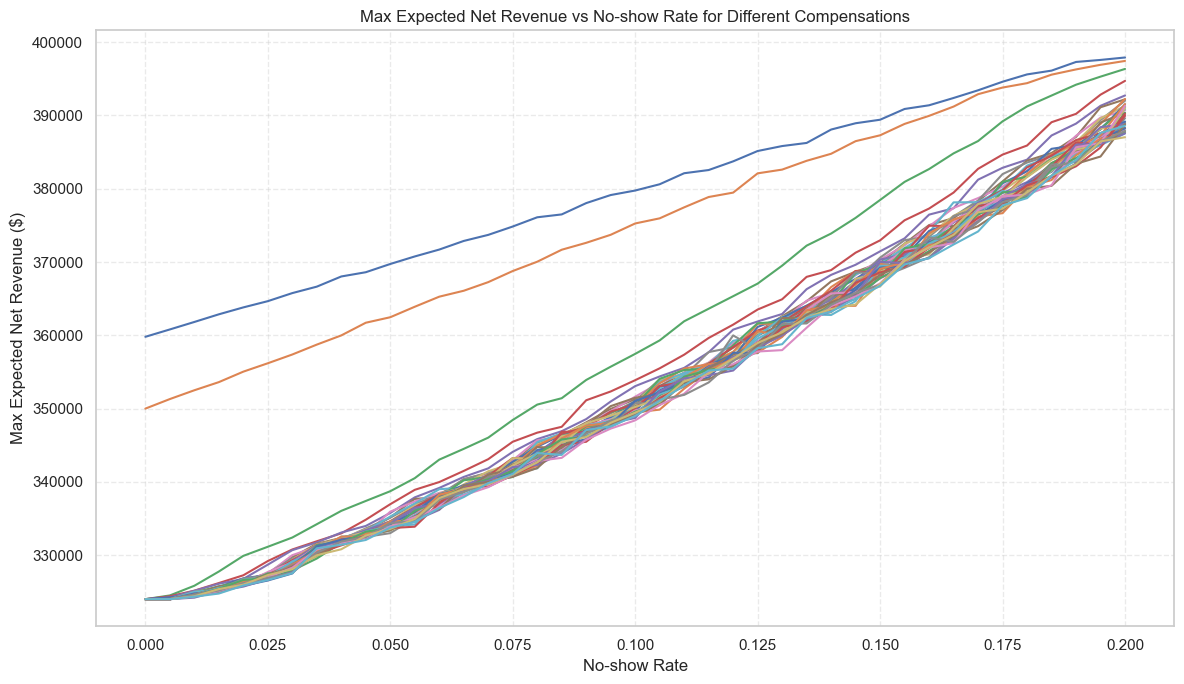

In [24]:
plt.figure(figsize=(12, 7))

# Loop over compensation values
for compensation in compensations_to_test:
    revenue_for_compensation = df[df['compensation_($)'] == compensation]
    plt.plot(revenue_for_compensation['no-show_rate'], revenue_for_compensation['max_expected_net_revenue_($)'], label=f'Compensation = ${compensation}')

plt.title('Max Expected Net Revenue vs No-show Rate for Different Compensations')
plt.xlabel('No-show Rate')
plt.ylabel('Max Expected Net Revenue ($)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()